<a href="https://colab.research.google.com/github/sakshisubedi/CSE_256_NLP/blob/main/cnn_lstm/imdb_fnal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import re
import string
from string import digits
from collections import Counter
from torchtext.data.utils import get_tokenizer
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from torchtext.vocab import GloVe
import time
import datetime
from torch.nn import functional as F
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data_folder = '/content/IMDB Dataset.csv'
df = pd.read_csv(data_folder)

label_mapping = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].map(label_mapping)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 40000
Test set size: 10000


In [3]:
train_df.head()

,review,sentiment
39087,That's what I kept asking myself during the ma...,0
30893,I did not watch the entire movie. I could not ...,0
45278,A touching love story reminiscent of In the M...,1
16398,This latter-day Fulci schlocker is a totally a...,0
13653,"First of all, I firmly believe that Norwegian ...",0


In [4]:
print(df['sentiment'].nunique())
print(df['sentiment'].value_counts())
print(df.info())

2
1    25000
0    25000
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None


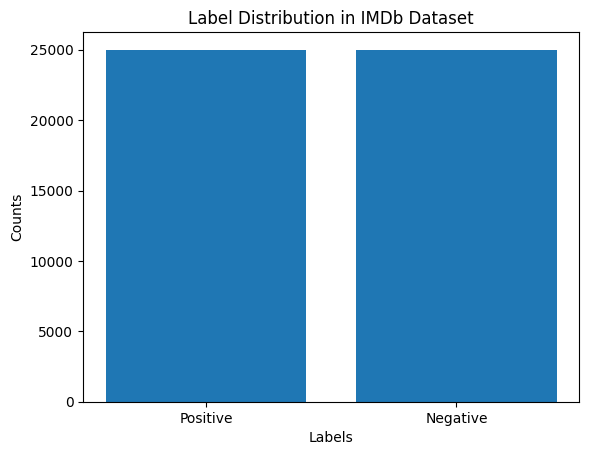

In [5]:

labels = ['Positive', 'Negative']
counts = [25000, 25000]

plt.bar(labels, counts)

plt.title('Label Distribution in IMDb Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')

plt.show()

In [6]:
# positive Example
print("Positive Example")
print(list(df[df['sentiment'] == 1]['review'])[6])

# Negative Example
print("Negative Example")
print(list(df[df['sentiment'] == 0]['review'])[9])

Positive Example
If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!
Negative Example
An awful film! It must have been up against some real stinkers to be nominated for the Golden Globe. They've taken the story of the first famous female Renaissance painter and mangled it beyond recognition. My complaint is not that they've taken liberties with the facts; if the story were good, that would perfectly fine. But it's simply bizarre -- by all accounts the true story of this artist would have made for a far better film, so why did they come up with this dishwater-dull script? I suppose there weren't enough naked people in the factual version. It's hurriedly capped off in the end with a summary of the artist's life -- we could have saved ourselves a couple of hours if they'd favored the rest of the film with same brevity.


In [7]:
stop_words = set(stopwords.words('english'))

In [8]:

tokenizer = get_tokenizer('basic_english')


def stringprocess(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"http\S+","URL", text)
    text = re.sub(r"@", "", text)
    text = re.sub(r"[^A-Za-z0-9()!?\'\`\"]", " ", text)
    text = re.sub("\s{2,}", " ", text)
    text = text.strip(' ')
    text = text.lower()

    return text

def tokenprocess(text):
    text_tokens = tokenizer(text)
    filtered_tokens = [token for token in text_tokens if token not in stop_words]
    return filtered_tokens


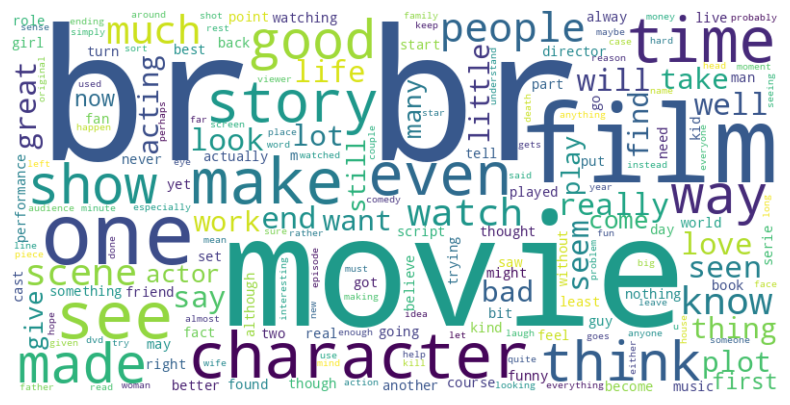

In [9]:
r = df["review"]
r = r.apply(stringprocess)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(r))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
word_tokens = list(r.apply(tokenprocess))

word_tokens_flat = [item for sublist in word_tokens for item in sublist]

vocab = set()
for data_point in word_tokens:
    vocab.update(data_point)

word_frequency = {}
for word in word_tokens_flat:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

threshold = 4

vocab = [word for word in vocab if word_frequency[word] >= threshold]

vocab = list(vocab)
vocab = ['<pad>'] + vocab

token_counts = []
for data_point in word_tokens:
    token_count = len(data_point)
    token_counts.append(token_count)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, max_length=500):
        self.data = df['review']
        self.targets = df['sentiment']
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.vocab_dict = {token: index for index, token in enumerate(vocab)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data.iloc[index]
        data_point = stringprocess(data_point)
        word_tokens = tokenprocess(data_point)
        target = self.targets.iloc[index]
        truncated_data = word_tokens[:self.max_length]
        data_ids = [self.vocab_dict[word] for word in truncated_data if self.vocab_dict.get(word) is not None]

        return torch.tensor(data_ids), target

In [11]:

glove = GloVe(name='6B', dim=100)

embedding_matrix = np.zeros((len(vocab), 100))

for i, token in enumerate(vocab):
    embedding_matrix[i] = glove[token]

np.save('embeddings.npy', embedding_matrix)

In [12]:
embedding_matrix = np.load('/content/embeddings.npy')

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import time

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    inputs, labels = zip(*batch)
    input_lengths = [len(x) for x in inputs]
    padded_inputs = pad_sequence(inputs, batch_first=True)
    return padded_inputs, torch.tensor(labels, dtype=torch.float32)

train_dataset = CustomDataset(train_df, tokenizer, vocab)
test_dataset = CustomDataset(test_df, tokenizer, vocab)



In [14]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [15]:
batch = next(iter(train_dataloader))
sentence, label = batch

In [16]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(LSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.sigmoid(self.decoder(encoding).squeeze())

        return outs

In [17]:
embed_size, num_hiddens, num_layers, device = 100, 100, 2, torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = LSTM(len(vocab), embed_size, num_hiddens, num_layers)

net.to(device)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights)

LSTM(
  (embedding): Embedding(44127, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
net.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
net.embedding.weight.requires_grad = False

In [19]:


def compute_acc(preds, labels):
    correct = sum((preds>0.5) == labels)
    acc = float(correct) / float(len(labels.data)) * 100.0
    return acc

In [20]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:

def train(model, optimizer, num_epochs, train_dataloader, val_dataloader, device, loss, show_every):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch_i in range(0, num_epochs):

        store_train_loss = []
        store_train_acc = []
        store_val_loss = []
        store_val_acc = []
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
        print('Training...')
        t0 = time.time()
        total_loss = 0

        model.train()


        for i, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)

            inputs_ids = batch[0]
            labels = batch[1]

            optimizer.zero_grad()

   
            outputs = model(inputs_ids)

            train_loss = loss(outputs, labels)
            train_acc = compute_acc(outputs, labels)

            store_train_loss.append(train_loss.item())
            store_train_acc.append(train_acc)

            train_loss.backward()
            optimizer.step()

            if i % show_every == 0 and not i == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {} / {}.'.format(i, len(train_dataloader)))
                print('Training loss: %.3f  Training acc: %.3f'%(np.mean(store_train_loss[-show_every:]), np.mean(store_train_acc[-show_every:])) )
        train_losses.append(np.mean(store_train_loss))
        train_accuracies.append(np.mean(store_train_acc))

        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        print("")
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)

            inputs_ids = batch[0]
            labels = batch[1]
            with torch.no_grad():

                  outputs = model(inputs_ids)



            val_loss = loss(outputs, labels)
            val_acc = compute_acc(outputs, labels)

            store_val_loss.append(val_loss.item())
            store_val_acc.append(val_acc)

        mean_val_loss = np.mean(store_val_loss)
        val_losses.append(mean_val_loss)
        val_accuracies.append(np.mean(store_val_acc))
        print("Epoch {}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format
        (epoch_i, train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1]))

    return train_losses, val_losses, train_accuracies, val_accuracies



In [22]:
lr =  0.01
num_epochs = 7
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.BCELoss()

In [23]:
train_losses, test_losses, train_accuracies, test_accuracies = train(net, optimizer, num_epochs, train_dataloader,
                                          test_dataloader, device, loss, show_every=200)



======== Epoch 1 / 7 ========
Training...
  Batch 200 / 1250.
Training loss: 0.600  Training acc: 68.438
  Batch 400 / 1250.
Training loss: 0.465  Training acc: 78.672
  Batch 600 / 1250.
Training loss: 0.395  Training acc: 82.891
  Batch 800 / 1250.
Training loss: 0.381  Training acc: 83.969
  Batch 1000 / 1250.
Training loss: 0.371  Training acc: 84.094
  Batch 1200 / 1250.
Training loss: 0.361  Training acc: 84.578
  Training epoch took: 0:00:37

Running Validation...
Epoch 0: Train Loss: 0.4266, Validation Loss: 0.3358, Train Accuracy: 80.58%, Validation Accuracy: 85.58%

======== Epoch 2 / 7 ========
Training...
  Batch 200 / 1250.
Training loss: 0.317  Training acc: 86.625
  Batch 400 / 1250.
Training loss: 0.330  Training acc: 86.391
  Batch 600 / 1250.
Training loss: 0.333  Training acc: 85.766
  Batch 800 / 1250.
Training loss: 0.333  Training acc: 86.375
  Batch 1000 / 1250.
Training loss: 0.332  Training acc: 85.578
  Batch 1200 / 1250.
Training loss: 0.331  Training acc: 8

In [24]:
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title("Losses over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title("Accuracies over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim((50,100))
    axs[1].legend()

    plt.tight_layout()

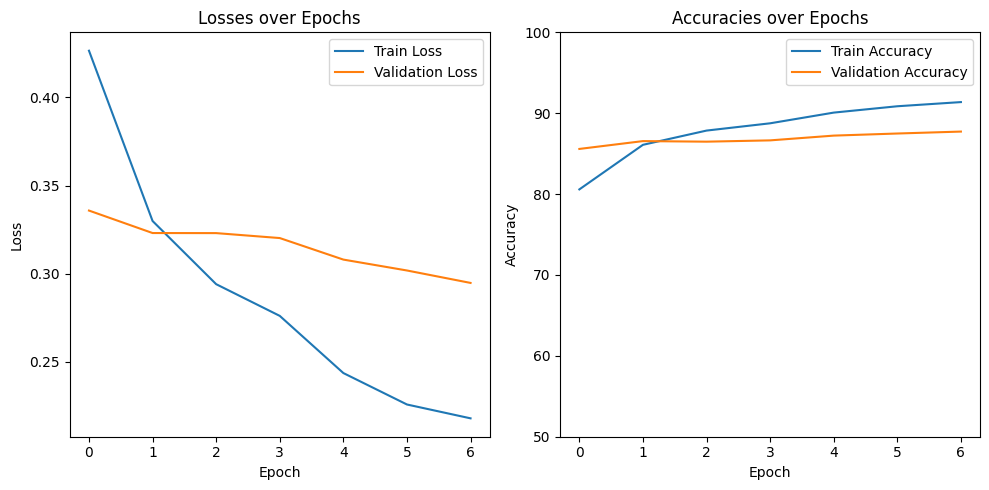

In [25]:
plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies)

In [26]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(*kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2*embed_size, c, k))
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        embeddings = embeddings.permute(0, 2, 1)
        encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) for conv in self.convs ], dim=1 )
        outputs = self.decoder(self.dropout(encoding))
        return self.sigmoid(outputs.squeeze())


In [27]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]

net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)
net.apply(init_weights)

TextCNN(
  (embedding): Embedding(44127, 100)
  (constant_embedding): Embedding(44127, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=1, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
  (sigmoid): Sigmoid()
)

In [28]:
net.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
net.constant_embedding.weight.data.copy_(torch.tensor(embedding_matrix))
net.constant_embedding.weight.requires_grad = False


In [29]:
lr = 0.001
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.BCELoss()

In [30]:
train_losses, test_losses, train_accuracies, test_accuracies = train(net, optimizer, num_epochs, train_dataloader,
                                          test_dataloader, device, loss, show_every=200)


======== Epoch 1 / 5 ========
Training...
  Batch 200 / 1250.
Training loss: 0.560  Training acc: 73.141
  Batch 400 / 1250.
Training loss: 0.434  Training acc: 81.812
  Batch 600 / 1250.
Training loss: 0.382  Training acc: 83.719
  Batch 800 / 1250.
Training loss: 0.334  Training acc: 85.500
  Batch 1000 / 1250.
Training loss: 0.300  Training acc: 87.656
  Batch 1200 / 1250.
Training loss: 0.282  Training acc: 88.297
  Training epoch took: 0:00:58

Running Validation...
Epoch 0: Train Loss: 0.3787, Validation Loss: 0.2608, Train Accuracy: 83.50%, Validation Accuracy: 89.27%

======== Epoch 2 / 5 ========
Training...
  Batch 200 / 1250.
Training loss: 0.210  Training acc: 92.219
  Batch 400 / 1250.
Training loss: 0.216  Training acc: 91.797
  Batch 600 / 1250.
Training loss: 0.211  Training acc: 91.688
  Batch 800 / 1250.
Training loss: 0.216  Training acc: 91.453
  Batch 1000 / 1250.
Training loss: 0.203  Training acc: 91.953
  Batch 1200 / 1250.
Training loss: 0.215  Training acc: 9

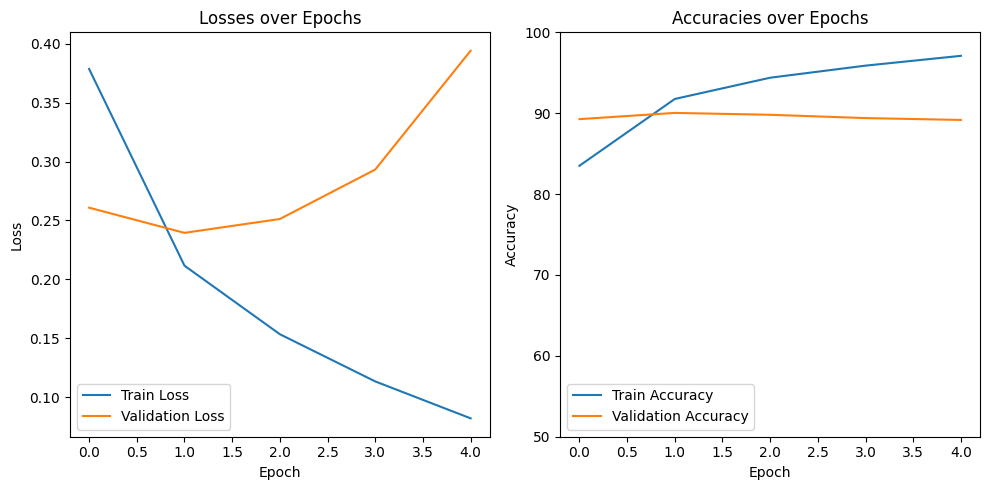

In [31]:
plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies)